In [1]:
import pandas as pd
# To fix - some messy slicing of pandas frames
pd.set_option('mode.chained_assignment', None)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import joblib

In [2]:
# Some data source

# Demographic data
# https://corgis-edu.github.io/corgis/csv/state_demographics/
# https://corgis-edu.github.io/corgis/datasets/csv/state_demographics/state_demographics.csv

# Poll data
# https://projects.fivethirtyeight.com/2020-general-data/presidential_polls_2020.csv'

# Electoral college votes
# https://raw.githubusercontent.com/chris-taylor/USElection/master/data/electoral-college-votes.csv

In [132]:
# State demographics as of 2016
state_demo=pd.read_csv('https://corgis-edu.github.io/corgis/datasets/csv/state_demographics/state_demographics.csv')

# Electoral college votes by state 
elec_college=pd.read_csv('../data/electoral-college-votes.csv', names=['State_full','State','Votes'])

# 2016 Election results by state
results_2016_state=pd.read_csv('../data/2016state.csv')

# 2012 Election results by state
results_2012_state=pd.read_excel('../data/US Presidential Election 2012 By State.xlsx',names=['State', 'Democratic Party', 'Republican Party', 'Libertarian Party',
       'Green Party', 'Others', 'Total Votes'])

# 538's excellent polling database
polls_pres=pd.read_csv('https://projects.fivethirtyeight.com/2020-general-data/presidential_polls_2020.csv')

polls_pres_ave=pd.read_csv('https://projects.fivethirtyeight.com/2020-general-data/presidential_poll_averages_2020.csv')
polls_pres_ave['modeldate']=pd.to_datetime(polls_pres_ave['modeldate'])
polls_pres_ave=polls_pres_ave.set_index('modeldate').sort_index()

In [133]:
def get_538_poll_ave(state):

    trump=polls_pres_ave[ (polls_pres_ave['candidate_name']=='Donald Trump') &
                  (polls_pres_ave['state']==state)].tail(1)['pct_estimate'].values[0]

    biden=polls_pres_ave[ (polls_pres_ave['candidate_name']=='Joseph R. Biden Jr.') &
                  (polls_pres_ave['state']==state)].tail(1)['pct_estimate'].values[0]
    return biden*0.01,trump*0.01

def get_538_poll_ave_date_limited(state,date):
    
    date=pd.to_datetime(date,format="%d/%m/%Y")

    trump=polls_pres_ave[ (polls_pres_ave['candidate_name']=='Donald Trump') &
                  (polls_pres_ave['state']==state) &
                        (polls_pres_ave.index<date)].tail(1)['pct_estimate'].values[0]

    biden=polls_pres_ave[ (polls_pres_ave['candidate_name']=='Joseph R. Biden Jr.') &
                  (polls_pres_ave['state']==state)&
                        (polls_pres_ave.index<date)].tail(1)['pct_estimate'].values[0]
    return biden*0.01,trump*0.01


In [148]:
get_538_poll_ave_date_limited('Florida','01/9/2020')

(0.4932649, 0.43952959999999996)

In [99]:
# Some helper functions

# Get the full state name (e.g. 'Florida') from the short state name (e.g. 'FL')
def get_long_name_from_short(short_name):
    long_name=elec_college[elec_college['State']==short_name]['State_full'].values[0]
    return long_name

# And the same for long to short
def get_short_name_from_long(long_name):
    short_name=elec_college[elec_college['State_full']==long_name]['State'].values[0]
    return short_name

# Get the polls for a given state
def get_polls_for_state(state):
    dates=[]
    weights=[]
    biden=[]
    trump=[]
    
    unique_polls=polls_pres[polls_pres['state']==state]['poll_id'].unique()

    for p in unique_polls:
        sub=polls_pres[polls_pres['poll_id']==p]
        
        dates.append(sub['startdate'].iloc[0])
        weights.append(sub['weight'].iloc[0])
        biden.append(sub[sub['candidate_name']=='Joseph R. Biden Jr.']['pct'].iloc[0])
        trump.append(sub[sub['candidate_name']=='Donald Trump']['pct'].iloc[0])

    subdata=pd.DataFrame({'Date': dates,
                          'Weights' : weights,
                          'Trump' : trump,
                          'Biden' : biden,
                          })
    subdata['Date']=pd.to_datetime(subdata['Date'])
    subdata.index=subdata['Date']
    subdata=subdata.drop('Date',axis=1).sort_index()  
    return subdata

# # Get the weighted (by 538) polls for a given state
# # Ideally we get the last 3 polls but in some cases there are only 2, 1 or none
# def get_weighted_norm_poll_vote_share(state):
#     vote_shares=get_polls_for_state(get_long_name_from_short(state))
#     vote_shares['Biden_norm']=vote_shares['Biden']/(vote_shares['Biden']+vote_shares['Trump'])
#     vote_shares['Trump_norm']=vote_shares['Trump']/(vote_shares['Biden']+vote_shares['Trump'])
    
#     biden=0
#     trump=0
    
#     #  Really scrappy handling of available polls - to clean
#     if len(vote_shares)>2:
#         last_polls=vote_shares.tail(3)
#         last_polls_total_weight=last_polls['Weights'].sum()
#         last_polls['poll_frac']=last_polls['Weights']/last_polls_total_weight
        
#         biden = last_polls.iloc[0]['poll_frac']*last_polls.iloc[0]['Biden_norm'] + last_polls.iloc[1]['poll_frac']*last_polls.iloc[1]['Biden_norm']+last_polls.iloc[2]['poll_frac']*last_polls.iloc[2]['Biden_norm']
#         trump = last_polls.iloc[0]['poll_frac']*last_polls.iloc[0]['Trump_norm'] + last_polls.iloc[1]['poll_frac']*last_polls.iloc[1]['Trump_norm'] +last_polls.iloc[2]['poll_frac']*last_polls.iloc[2]['Trump_norm']

#     elif len(vote_shares)>1:
#         last_polls=vote_shares.tail(2)
#         last_polls_total_weight=last_polls['Weights'].sum()
#         last_polls['poll_frac']=last_polls['Weights']/last_polls_total_weight
        
#         biden = last_polls.iloc[0]['poll_frac']*last_polls.iloc[0]['Biden_norm'] + last_polls.iloc[1]['poll_frac']*last_polls.iloc[1]['Biden_norm']
#         trump = last_polls.iloc[0]['poll_frac']*last_polls.iloc[0]['Trump_norm'] + last_polls.iloc[1]['poll_frac']*last_polls.iloc[1]['Trump_norm'] 

#     else:
#         last_polls=vote_shares.tail(1)
#         biden = last_polls.iloc[0]['Biden_norm']
#         trump = last_polls.iloc[0]['Trump_norm']
    
#     return biden,trump

# def get_weighted_norm_poll_vote_share_date_limited(state,end_date):
#     vote_shares=get_polls_for_state(get_long_name_from_short(state))
#     vote_shares['Biden_norm']=vote_shares['Biden']/(vote_shares['Biden']+vote_shares['Trump'])
#     vote_shares['Trump_norm']=vote_shares['Trump']/(vote_shares['Biden']+vote_shares['Trump'])
    
#     vote_shares=vote_shares[vote_shares.index<end_date]
#     biden=0
#     trump=0
    
#     #  Really scrappy handling of available polls - to clean
#     if len(vote_shares)>2:
#         last_polls=vote_shares.tail(3)
#         last_polls_total_weight=last_polls['Weights'].sum()
#         last_polls['poll_frac']=last_polls['Weights']/last_polls_total_weight
        
#         biden = last_polls.iloc[0]['poll_frac']*last_polls.iloc[0]['Biden_norm'] + last_polls.iloc[1]['poll_frac']*last_polls.iloc[1]['Biden_norm']+last_polls.iloc[2]['poll_frac']*last_polls.iloc[2]['Biden_norm']
#         trump = last_polls.iloc[0]['poll_frac']*last_polls.iloc[0]['Trump_norm'] + last_polls.iloc[1]['poll_frac']*last_polls.iloc[1]['Trump_norm'] +last_polls.iloc[2]['poll_frac']*last_polls.iloc[2]['Trump_norm']

#     elif len(vote_shares)>1:
#         last_polls=vote_shares.tail(2)
#         last_polls_total_weight=last_polls['Weights'].sum()
#         last_polls['poll_frac']=last_polls['Weights']/last_polls_total_weight
        
#         biden = last_polls.iloc[0]['poll_frac']*last_polls.iloc[0]['Biden_norm'] + last_polls.iloc[1]['poll_frac']*last_polls.iloc[1]['Biden_norm']
#         trump = last_polls.iloc[0]['poll_frac']*last_polls.iloc[0]['Trump_norm'] + last_polls.iloc[1]['poll_frac']*last_polls.iloc[1]['Trump_norm'] 

#     else:
#         last_polls=vote_shares.tail(1)
#         biden = last_polls.iloc[0]['Biden_norm']
#         trump = last_polls.iloc[0]['Trump_norm']
    
#     return biden,trump

In [5]:
# Skip the first row of the 2012 results (metadata)
results_2012_state=results_2012_state.iloc[1:]

# Calculate the % of dem and rep votes in 2012
results_2012_state['dem_pc']=(results_2012_state['Democratic Party']/results_2012_state['Total Votes'])*100
results_2012_state['rep_pc']=(results_2012_state['Republican Party']/results_2012_state['Total Votes'])*100

In [6]:
# Get the dem and rep % vote share for 2012
def get_2012_vote_shares(state):
    state=get_short_name_from_long(state)
    dem=results_2012_state[results_2012_state['State']==state]['dem_pc'].values[0]
    rep=results_2012_state[results_2012_state['State']==state]['rep_pc'].values[0]
    return dem, rep

# Get the dem and rep % vote share for 2016
def get_2016_vote_shares(state):
    dem=results_2016_state[results_2016_state['State']==state]['percD'].values[0]
    rep=results_2016_state[results_2016_state['State']==state]['percR'].values[0]
    return dem, rep

In [7]:
# We only want (or need, for now) a subset of the demographic features - these are pretty self explanitory
features_to_use=['State',
#     'Age.Percent 65 and Older',
    'Education.Bachelor\'s Degree or Higher',
    'Education.High School or Higher',
#     'Employment.Nonemployer Establishments',
#     'Employment.Private Non-farm Employment',
#     'Employment.Private Non-farm Establishments',
#     'Ethnicities.American Indian and Alaska Native Alone',
#     'Ethnicities.Asian Alone', 'Ethnicities.Black Alone',
#     'Ethnicities.Hispanic or Latino',
#     'Ethnicities.Native Hawaiian and Other Pacific Islander Alone',
#     'Ethnicities.Two or More Races', 'Ethnicities.White Alone',
#     'Ethnicities.White Alone, not Hispanic or Latino',
#     'Housing.Homeownership Rate', 'Housing.Households',
#     'Housing.Housing Units', 'Housing.Median Value of Owner-Occupied Units',
#     'Housing.Persons per Household',
#     'Housing.Units in Multi-Unit Structures',
#     'Income.Median Houseold Income', 'Income.Per Capita Income',
#     'Income.Persons Below Poverty Level', 'Miscellaneous.Building Permits',
#     'Miscellaneous.Foreign Born',
    'Miscellaneous.Percent Female', 
#                  'Miscellaneous.Veterans',
]

# Filter by the features we want
state_demo_use=state_demo[features_to_use]
state_demo_use.head()

,State,Education.Bachelor's Degree or Higher,Education.High School or Higher,Miscellaneous.Percent Female
0,United States,28.8,86.0,50.8
1,Alabama,22.6,83.1,51.5
2,Alaska,27.5,91.6,47.4
3,Arizona,26.9,85.7,50.3
4,Arkansas,20.1,83.7,50.9


In [8]:
# Building our features and targets to train a model to replicate the 2016 results
# This will be our baseline - a model that predicts the 2016 result based on demographics and the 2012 result
# Features: Demographics, 2012 result
# Target: 2016 result

states=state_demo['State'].unique()

X=[]
Y=[]

for s in states:
#     'United States' isn't relenvat and 'DC' exist in the state list but there isn't demo data for it
    if s!='United States':
        if s!='District Of Columbia':
            demo_inputs=state_demo_use[state_demo_use['State']==s].drop('State',axis=1).values[0].tolist()
            dem_2012,rep_2012 = get_2012_vote_shares(s)
            demo_inputs.append(dem_2012)
            demo_inputs.append(rep_2012)

            X.append(demo_inputs)
            
            dem=results_2016_state[results_2016_state['State']==s]['percD'].values[0]
            rep=results_2016_state[results_2016_state['State']==s]['percR'].values[0]
            Y.append([dem,rep])

X=np.array(X)
Y=np.array(Y)

# This function is useful later when we want to build features for a given state (rather than all)
def get_features_state(s):
    demo_inputs=state_demo_use[state_demo_use['State']==s].drop('State',axis=1).values[0].tolist()
    dem_2012,rep_2012 = get_2012_vote_shares(s)
    demo_inputs.append(dem_2012)
    demo_inputs.append(rep_2012)

    return np.array(demo_inputs)
    

In [9]:
# Normalise the features
scaler = StandardScaler()
X=scaler.fit_transform(X)

scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 

['scaler.save']

In [10]:
# Check our shapes
# We have a TINY dataset - 50 states with 5 features
print('X shape: ',X.shape)
print('Y shape: ',Y.shape)

X shape:  (50, 5)
Y shape:  (50, 2)


In [11]:
# Create a pretty basic fully connected model
model = Sequential()
model.add(Dense(16, input_dim=X.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(8, kernel_initializer='normal'))
model.add(Dense(2, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_absolute_error', optimizer='adam')

In [12]:
# Track the validation accuracy and save the best model
checkpoint_path = "cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss',
                                                 save_weights_only=True,
                                                 verbose=0)


In [13]:
# Train model
# training a tiny dataset this many times is a bit questionable and overfitting is a danger
# but hey ho
history = model.fit(
    X,Y,
    epochs=2500,
    verbose=0,
    validation_split=0.2,
    callbacks=[cp_callback])

# Load the best weights back
model.load_weights(checkpoint_path)

print('Training Complete')



Training Complete


In [ ]:
# Save the model
# model.save('261020_baseline.h5') # saves compiled state
# model.save('271020_baseline.h5') # saves compiled state

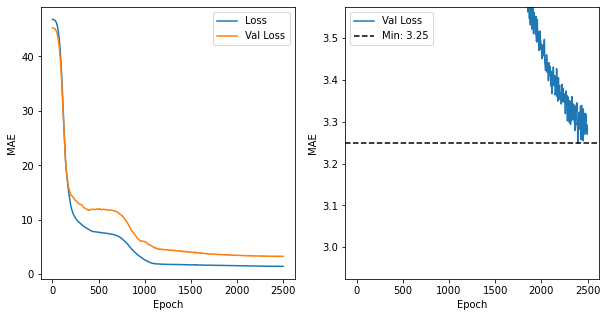

In [14]:
# Model seems to flatten out training around 2000 epochs
history.history.keys()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='Loss')
plt.plot(history.history['val_loss'],label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['val_loss'],label='Val Loss')
plt.ylim(0.9*np.min(history.history['val_loss']),1.1*np.min(history.history['val_loss']))
plt.axhline(y=np.min(history.history['val_loss']),ls='--',c='k',label='Min: '+
            str(np.round(np.min(history.history['val_loss']),2)))
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

In [15]:
# Now let's calculate the results of the 2016 election using the model
rep_state_wins=[]
dem_state_wins=[]
rep_elec_coll_votes=0
dem_elec_coll_votes=0

# Hacky Alaska workaround! - For some reason the data seems to be missing Alaska electoral votes
print('Processing AK')
print('\t Republicans win AK')
rep_state_wins.append('AK')
rep_elec_coll_votes += elec_college[elec_college['State']=='AK']['Votes'].values[0]


for s in states:
    if s!='United States':
        if s!='District Of Columbia':
            print('Processing '+s)
            results=model.predict(scaler.transform(get_features_state(s).reshape(1,-1)))
            if results[0][1]>results[0][0]:
                rep_state_wins.append(s)
                rep_elec_coll_votes += elec_college[elec_college['State']==get_short_name_from_long(s)]['Votes'].values[0]
                print('\t Republicans win '+s)
            elif results[0][1] < results[0][0]:
                dem_state_wins.append(s)
                dem_elec_coll_votes += elec_college[elec_college['State']==get_short_name_from_long(s)]['Votes'].values[0]
                print('\t Democrats win '+s)

Processing AK
	 Republicans win AK
Processing Alabama
	 Republicans win Alabama
Processing Alaska
	 Republicans win Alaska
Processing Arizona
	 Republicans win Arizona
Processing Arkansas
	 Republicans win Arkansas
Processing California
	 Democrats win California
Processing Colorado
	 Democrats win Colorado
Processing Connecticut
	 Democrats win Connecticut
Processing Delaware
	 Democrats win Delaware
Processing Florida
	 Republicans win Florida
Processing Georgia
	 Republicans win Georgia
Processing Hawaii
	 Democrats win Hawaii
Processing Idaho
	 Republicans win Idaho
Processing Illinois
	 Democrats win Illinois
Processing Indiana
	 Republicans win Indiana
Processing Iowa
	 Republicans win Iowa
Processing Kansas
	 Republicans win Kansas
Processing Kentucky
	 Republicans win Kentucky
Processing Louisiana
	 Republicans win Louisiana
Processing Maine
	 Democrats win Maine
Processing Maryland
	 Democrats win Maryland
Processing Massachusetts
	 Democrats win Massachusetts
Processing Michi

In [16]:
# Look at the final results:
print('Rep Elec College Votes: '+str(rep_elec_coll_votes)+' and Dem Elec College Votes: '+str(dem_elec_coll_votes))
print('Total: '+str(rep_elec_coll_votes+dem_elec_coll_votes))

# and compare with the actual results
# https://en.wikipedia.org/wiki/2016_United_States_presidential_election
print('Actual results: Rep: 306, Dem: 232')

Rep Elec College Votes: 308 and Dem Elec College Votes: 230
Total: 538
Actual results: Rep: 306, Dem: 232


In [17]:
# Let's get some polls for a random state:
get_polls_for_state('Florida').tail(3)

,Weights,Trump,Biden
Date,,,
2020-10-24,1.105862,48.13,50.16
2020-10-25,1.509852,47.00,51.00
2020-10-26,1.001185,47.00,50.00


In [18]:
# Let's the get the (538) weighted average poll
wa_poll=get_weighted_norm_poll_vote_share(get_short_name_from_long('Georgia'))
print('Current Poll: Dem:',wa_poll[0]*100,' and Rep:',wa_poll[1]*100)

Current Poll: Dem: 51.304697097565565  and Rep: 48.69530290243443


In [123]:
# Now if we want to make predictions for 2020:
#  we use the same mode
#  we use the same demographics (poor assumption, this will have changed)
#  we use the 2016 as the benchmark (where we used 2012 previously)

# Get features and POLL outputs for re-tuning the model

def make_new_feature_poll_based(s):
    demo_inputs=state_demo_use[state_demo_use['State']==s].drop('State',axis=1).values[0].tolist()
    dem_2016,rep_2016 = get_2016_vote_shares(s)
    demo_inputs.append(dem_2016)
    demo_inputs.append(rep_2016)
    
    Y=[]
#     polls=get_weighted_norm_poll_vote_share(get_short_name_from_long(s))
    polls=get_538_poll_ave(s)
    dem_poll=100*polls[0]
    rep_poll=100*polls[1]
    
    Y.append(dem_poll)
    Y.append(rep_poll)
    
    return np.array(demo_inputs),np.array(Y)

def make_new_feature_poll_based_time_limited(s,end_date):
    demo_inputs=state_demo_use[state_demo_use['State']==s].drop('State',axis=1).values[0].tolist()
    dem_2016,rep_2016 = get_2016_vote_shares(s)
    demo_inputs.append(dem_2016)
    demo_inputs.append(rep_2016)
    
    Y=[]
#     polls=get_weighted_norm_poll_vote_share_date_limited(get_short_name_from_long(s),end_date)
    polls=get_538_poll_ave_date_limited(s,end_date)

    dem_poll=100*polls[0]
    rep_poll=100*polls[1]
    
    Y.append(dem_poll)
    Y.append(rep_poll)
    
    return np.array(demo_inputs),np.array(Y)

# Get features for 2020 predictions
def make_new_feature_2016_based(s):
    demo_inputs=state_demo_use[state_demo_use['State']==s].drop('State',axis=1).values[0].tolist()
    dem_2016,rep_2016 = get_2016_vote_shares(s)
    demo_inputs.append(dem_2016)
    demo_inputs.append(rep_2016)

    return np.array(demo_inputs)

In [100]:
#  Running all in one cell

# Get a new single instance of features based on polls for a given set of states (initially just one)
model_run_rep_ev=[]
model_run_dem_ev=[]

# test_states=['Florida']
test_states=['Florida','Wisconsin','Pennsylvania','North Carolina','Michigan']
for s in test_states:
    
    wa_poll=get_538_poll_ave(s)

    print('Modelling Election based on latest polls from '+s)
    X_new=[]
    Y_new=[]

    x,y=make_new_feature_poll_based(s)
    X_new.append(x)
    Y_new.append(y)

    X_new=np.array(X_new)
    Y_new=np.array(Y_new)

    X_new=scaler.transform(X_new)

    # Make a new model that re-tunes the baseline model
    new_model = tf.keras.models.load_model('271020_baseline.h5')

    error= np.abs(new_model.predict(scaler.transform(make_new_feature_2016_based(s).reshape(1,-1)))[0][0] - wa_poll[0]*100)

    # Let's do a maximum of 100 re-trains of the model on the single example
    for i in range(0,100):
        new_model.fit(
            X_new,Y_new,
            epochs=1,
            verbose=0
        )
        error= np.abs(new_model.predict(scaler.transform(make_new_feature_2016_based(s).reshape(1,-1)))[0][0] - wa_poll[0]*100)
    #     We've got the model close enough
        if error<0.25:
            break

    model_results=new_model.predict(scaler.transform(make_new_feature_2016_based(s).reshape(1,-1)))
    print('\nModel Outputs: Dem:',np.round(model_results[0][0],2),' and Rep:',np.round(model_results[0][1],2))
    print('Current Poll: Dem:',np.round(wa_poll[0]*100,2),' and Rep:',np.round(wa_poll[1]*100,2))

    # Let's predict the 2020 election based on this re-tuned model

    rep_state_wins=[]
    dem_state_wins=[]
    rep_elec_coll_votes=0
    dem_elec_coll_votes=0

    # Hacky Alaska workaround!
    rep_state_wins.append('AK')
    rep_elec_coll_votes += elec_college[elec_college['State']=='AK']['Votes'].values[0]


    for state in states:
        if state!='United States':
            if state!='District Of Columbia':
                results=new_model.predict(scaler.transform(make_new_feature_2016_based(state).reshape(1,-1)))
                if results[0][1]>results[0][0]:
                    rep_state_wins.append(state)
                    rep_elec_coll_votes += elec_college[elec_college['State']==get_short_name_from_long(state)]['Votes'].values[0]
                elif results[0][1] < results[0][0]:
                    dem_state_wins.append(state)
                    dem_elec_coll_votes += elec_college[elec_college['State']==get_short_name_from_long(state)]['Votes'].values[0]

    print('\nTrump Electoral College Votes: '+str(rep_elec_coll_votes)+'\nBiden Electoral College Votes: '+str(dem_elec_coll_votes))
    print('\n-------------------------\n')
    model_run_rep_ev.append(rep_elec_coll_votes)
    model_run_dem_ev.append(dem_elec_coll_votes)

r_ev=str(np.round(np.mean(model_run_rep_ev),0))
d_ev=str(np.round(np.mean(model_run_dem_ev),0))
print('\n Implied Mean Republican Electoral College Votes: '+r_ev)
print('\n Implied Mean Democrat Electoral College Votes: '+d_ev)

Modelling Election based on latest polls from Florida

Model Outputs: Dem: 52.34  and Rep: 47.6
Current Poll: Dem: 48.78  and Rep: 46.37

Trump Electoral College Votes: 179
Biden Electoral College Votes: 359

-------------------------

Modelling Election based on latest polls from Wisconsin

Model Outputs: Dem: 51.63  and Rep: 46.71
Current Poll: Dem: 51.87  and Rep: 43.08

Trump Electoral College Votes: 150
Biden Electoral College Votes: 388

-------------------------

Modelling Election based on latest polls from Pennsylvania

Model Outputs: Dem: 51.78  and Rep: 48.16
Current Poll: Dem: 50.21  and Rep: 44.84

Trump Electoral College Votes: 153
Biden Electoral College Votes: 385

-------------------------

Modelling Election based on latest polls from North Carolina

Model Outputs: Dem: 48.88  and Rep: 51.39
Current Poll: Dem: 48.83  and Rep: 46.82

Trump Electoral College Votes: 288
Biden Electoral College Votes: 250

-------------------------

Modelling Election based on latest poll

In [125]:
#
#  For back testing - specify a last date of polls to include
#
#  Running backtest! in one cell
end_date='31/10/2020'

# Get a new single instance of features based on polls for a given set of states (initially just one)
model_run_rep_ev=[]
model_run_dem_ev=[]

# test_states=['Florida']
test_states=['Florida','Wisconsin','Pennsylvania','North Carolina','Michigan']
for s in test_states:
    
#     wa_poll=get_weighted_norm_poll_vote_share_date_limited(get_short_name_from_long(s),end_date)
    wa_poll=get_538_poll_ave_date_limited(s, end_date)
    print('Modelling Election based on latest polls from '+s)
    X_new=[]
    Y_new=[]

    x,y=make_new_feature_poll_based_time_limited(s,end_date)
    X_new.append(x)
    Y_new.append(y)

    X_new=np.array(X_new)
    Y_new=np.array(Y_new)

    X_new=scaler.transform(X_new)

    # Make a new model that re-tunes the baseline model
    new_model = tf.keras.models.load_model('271020_baseline.h5')

    error= np.abs(new_model.predict(scaler.transform(make_new_feature_2016_based(s).reshape(1,-1)))[0][0] - wa_poll[0]*100)

    # Let's do a maximum of 100 re-trains of the model on the single example
    for i in range(0,100):
        new_model.fit(
            X_new,Y_new,
            epochs=1,
            verbose=0
        )
        error= np.abs(new_model.predict(scaler.transform(make_new_feature_2016_based(s).reshape(1,-1)))[0][0] - wa_poll[0]*100)
    #     We've got the model close enough
        if error<0.25:
            break

    model_results=new_model.predict(scaler.transform(make_new_feature_2016_based(s).reshape(1,-1)))
    print('\nModel Outputs: Dem:',np.round(model_results[0][0],2),' and Rep:',np.round(model_results[0][1],2))
    print('Current Poll: Dem:',np.round(wa_poll[0]*100,2),' and Rep:',np.round(wa_poll[1]*100,2))

    # Let's predict the 2020 election based on this re-tuned model

    rep_state_wins=[]
    dem_state_wins=[]
    rep_elec_coll_votes=0
    dem_elec_coll_votes=0

    # Hacky Alaska workaround!
    rep_state_wins.append('AK')
    rep_elec_coll_votes += elec_college[elec_college['State']=='AK']['Votes'].values[0]


    for state in states:
        if state!='United States':
            if state!='District Of Columbia':
                results=new_model.predict(scaler.transform(make_new_feature_2016_based(state).reshape(1,-1)))
                if results[0][1]>results[0][0]:
                    rep_state_wins.append(state)
                    rep_elec_coll_votes += elec_college[elec_college['State']==get_short_name_from_long(state)]['Votes'].values[0]
                elif results[0][1] < results[0][0]:
                    dem_state_wins.append(s)
                    dem_elec_coll_votes += elec_college[elec_college['State']==get_short_name_from_long(state)]['Votes'].values[0]

    print('\nTrump Electoral College Votes: '+str(rep_elec_coll_votes)+'\nBiden Electoral College Votes: '+str(dem_elec_coll_votes))
    print('\n-------------------------\n')
    model_run_rep_ev.append(rep_elec_coll_votes)
    model_run_dem_ev.append(dem_elec_coll_votes)

r_ev=str(np.round(np.mean(model_run_rep_ev),0))
d_ev=str(np.round(np.mean(model_run_dem_ev),0))
print('\n Implied Mean Republican Electoral College Votes: '+r_ev)
print('\n Implied Mean Democrat Electoral College Votes: '+d_ev)

Modelling Election based on latest polls from Florida

Model Outputs: Dem: 48.92  and Rep: 45.85
Current Poll: Dem: 48.78  and Rep: 46.37

Trump Electoral College Votes: 203
Biden Electoral College Votes: 335

-------------------------

Modelling Election based on latest polls from Wisconsin

Model Outputs: Dem: 51.78  and Rep: 43.86
Current Poll: Dem: 51.87  and Rep: 43.08

Trump Electoral College Votes: 150
Biden Electoral College Votes: 388

-------------------------

Modelling Election based on latest polls from Pennsylvania

Model Outputs: Dem: 50.42  and Rep: 44.89
Current Poll: Dem: 50.21  and Rep: 44.84

Trump Electoral College Votes: 153
Biden Electoral College Votes: 385

-------------------------

Modelling Election based on latest polls from North Carolina

Model Outputs: Dem: 48.97  and Rep: 46.7
Current Poll: Dem: 48.83  and Rep: 46.82

Trump Electoral College Votes: 203
Biden Electoral College Votes: 335

-------------------------

Modelling Election based on latest poll

In [157]:
import requests, json

def get_historical_ev(date):
    url = 'http://127.0.0.1:5000/api/swingstatesdatelimited'
    data={'date': date}
    data = json.dumps(data)
    headers = {'content-type': 'application/json', 'Accept-Charset': 'UTF-8'}
    r = requests.post(url, data=data, headers=headers)
#     print(r)
    return json.loads(r.text)['Biden'], json.loads(r.text)['Trump']

In [166]:
trump_ev=[]
biden_ev=[]

dates=['03/03/2020','10/03/2020','17/03/2020','24/03/2020',
       '31/03/2020','06/04/2020','13/04/2020','20/04/2020','27/04/2020','03/05/2020','10/05/2020',
       '17/05/2020','24/05/2020','01/06/2020','08/06/2020','15/06/2020','22/06/2020','29/06/2020',
       '05/07/2020','12/07/2020','17/07/2020','24/07/2020','01/08/2020','08/08/2020','15/08/2020',
       '22/08/2020','29/08/2020','05/09/2020','12/09/2020','19/09/2020','20/09/2020','21/09/2020',
       '22/09/2020','23/09/2020','24/09/2020','25/09/2020','26/09/2020','27/09/2020','28/09/2020',
       '29/09/2020','30/09/2020','01/10/2020','02/10/2020','03/10/2020','04/10/2020','05/10/2020',
       '06/10/2020','07/10/2020','08/10/2020','09/10/2020','10/10/2020',
       '11/10/2020','12/10/2020','13/10/2020','14/10/2020','15/10/2020','16/10/2020','17/10/2020',
       '18/10/2020','19/10/2020','20/10/2020','21/10/2020','22/10/2020','23/10/2020','24/10/2020',
       '25/10/2020','26/10/2020','27/10/2020','28/10/2020','29/10/2020','30/10/2020']

# dates=['28/07/2020','29/10/2020','30/10/2020']

for d in dates:
    print('Processing '+d)
#     get_historical_ev(d)
    biden, trump = get_historical_ev(d)
    print('\tBiden: '+biden)
    print('\tTrump: '+trump)
    trump_ev.append(trump)
    biden_ev.append(biden)

Processing 03/03/2020
	Biden: 355.0
	Trump: 183.0
Processing 10/03/2020
	Biden: 356.0
	Trump: 182.0
Processing 17/03/2020
	Biden: 356.0
	Trump: 182.0
Processing 24/03/2020
	Biden: 356.0
	Trump: 182.0
Processing 31/03/2020
	Biden: 362.0
	Trump: 176.0
Processing 06/04/2020
	Biden: 362.0
	Trump: 176.0
Processing 13/04/2020
	Biden: 360.0
	Trump: 178.0
Processing 20/04/2020
	Biden: 362.0
	Trump: 176.0
Processing 27/04/2020
	Biden: 365.0
	Trump: 173.0
Processing 03/05/2020
	Biden: 370.0
	Trump: 168.0
Processing 10/05/2020
	Biden: 371.0
	Trump: 167.0
Processing 17/05/2020
	Biden: 371.0
	Trump: 167.0
Processing 24/05/2020
	Biden: 354.0
	Trump: 184.0
Processing 01/06/2020
	Biden: 351.0
	Trump: 187.0
Processing 08/06/2020
	Biden: 371.0
	Trump: 167.0
Processing 15/06/2020
	Biden: 376.0
	Trump: 162.0
Processing 22/06/2020
	Biden: 361.0
	Trump: 177.0
Processing 29/06/2020
	Biden: 376.0
	Trump: 162.0
Processing 05/07/2020
	Biden: 378.0
	Trump: 160.0
Processing 12/07/2020
	Biden: 376.0
	Trump: 162.0


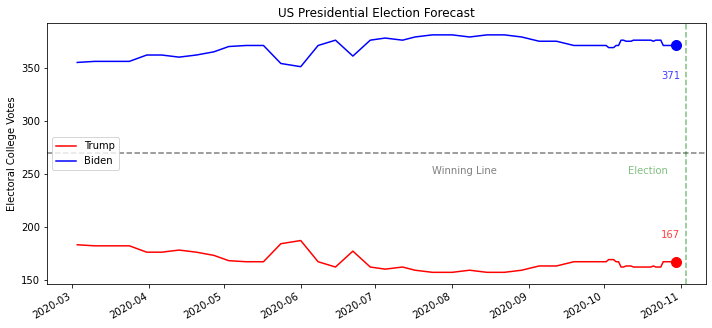

In [210]:
trump_ev_fl=[]
biden_ev_fl=[]
for i in range(0,len(trump_ev)):
    trump_ev_fl.append(float(trump_ev[i]))
    biden_ev_fl.append(float(biden_ev[i]))
    
dates=['03/03/2020','10/03/2020','17/03/2020','24/03/2020',
       '31/03/2020','06/04/2020','13/04/2020','20/04/2020','27/04/2020','03/05/2020','10/05/2020',
       '17/05/2020','24/05/2020','01/06/2020','08/06/2020','15/06/2020','22/06/2020','29/06/2020',
       '05/07/2020','12/07/2020','17/07/2020','24/07/2020','01/08/2020','08/08/2020','15/08/2020',
       '22/08/2020','29/08/2020','05/09/2020','12/09/2020','19/09/2020','20/09/2020','21/09/2020',
       '22/09/2020','23/09/2020','24/09/2020','25/09/2020','26/09/2020','27/09/2020','28/09/2020',
       '29/09/2020','30/09/2020','01/10/2020','02/10/2020','03/10/2020','04/10/2020','05/10/2020',
       '06/10/2020','07/10/2020','08/10/2020','09/10/2020','10/10/2020',
       '11/10/2020','12/10/2020','13/10/2020','14/10/2020','15/10/2020','16/10/2020','17/10/2020',
       '18/10/2020','19/10/2020','20/10/2020','21/10/2020','22/10/2020','23/10/2020','24/10/2020',
       '25/10/2020','26/10/2020','27/10/2020','28/10/2020','29/10/2020','30/10/2020']

dates=pd.to_datetime(dates,format='%d/%m/%Y')
rep_ev=[222,222,172,172,172,172,178,149,195,178,178,148,190,198,198,167,186,166,165,178,161,170,188,179,171,139,157,147,165,160,161,152,179,173,173,160,168,155,160,161,155,166,157,172,160,160,161,181,162,162,167,172,176,187,186,172,136,166,173,161,160,160,160,171,173,169,166,168,158,158,158,163,166,163,
        163,160,160,163,160,154,167]
dem_ev=[316,316,366,366,366,366,360,389,343,360,360,390,348,340,340,371,352,372,373,360,377,368,350,359,367,399,381,391,373,378,377,386,359,365,365,378,370,383,378,377,383,372,381,366,378,378,377,367,376,376,371,366,362,351,352,366,402,372,365,377,378,378,378,367,366,369,372,370,380,380,380,375,372,375,
        375,378,378,375,378,384,371]

# # text_date=['26/10/2020']

plt.figure(figsize=(10,5))
plt.title('US Presidential Election Forecast')
plt.plot(dates,trump_ev_fl,c='r',label='Trump')
plt.plot(dates,biden_ev_fl,c='b',label='Biden')

plt.scatter(x=dates[-1],y=rep_ev[-1],c='r',s=100)
plt.scatter(x=dates[-1],y=dem_ev[-1],c='b',s=100)

plt.axhline(y=270,ls='--',c='k',alpha=0.5)
plt.text(x=dates[-50],y=250,s='Winning Line',alpha=0.5)

plt.text(x=dates[-7],y=190,s=str(rep_ev[-1]),alpha=0.75,c='r')
plt.text(x=dates[-7],y=340,s=str(dem_ev[-1]),alpha=0.75,c='b')
# plt.ylim(0,538)
plt.ylabel('Electoral College Votes')
plt.legend(loc='center left')

# import matplotlib.dates as mdates
# # Set the locator
# locator = mdates.MonthLocator()  # every month
# # Specify the format - %b gives us Jan, Feb...
# fmt = mdates.DateFormatter('%b-%Y')
# X = plt.gca().xaxis
# X.set_major_locator(locator)
# # Specify formatter
# X.set_major_formatter(fmt)
# plt.xlim(pd.to_datetime('15/09/2020'),pd.to_datetime('11/05/2020'))
plt.axvline(x=pd.to_datetime('11/03/2020'),ls='--',c='g',alpha=0.5)
plt.text(x=dates[-20],y=250,s='Election',c='g',alpha=0.5)

plt.tight_layout()
plt.gcf().autofmt_xdate()
